In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.autograd import Variable

# Téléchargement de la database

In [2]:
!wget https://eva-engines.s3.eu-west-3.amazonaws.com/data/lunettes/0/Archive.zip

--2020-06-14 11:33:39--  https://eva-engines.s3.eu-west-3.amazonaws.com/data/lunettes/0/Archive.zip
Resolving eva-engines.s3.eu-west-3.amazonaws.com (eva-engines.s3.eu-west-3.amazonaws.com)... 52.95.155.48
Connecting to eva-engines.s3.eu-west-3.amazonaws.com (eva-engines.s3.eu-west-3.amazonaws.com)|52.95.155.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240028571 (229M) [application/zip]
Saving to: ‘Archive.zip’

Archive.zip         100%[===================>] 228.91M  98.9MB/s    in 2.3s    

2020-06-14 11:33:41 (98.9 MB/s) - ‘Archive.zip’ saved [240028571/240028571]



In [3]:
!unzip Archive.zip

Archive:  Archive.zip
   creating: 0/
  inflating: 0/EVA_1571669124353.jpg  
  inflating: 0/EVA_1567420635229.jpg  
  inflating: 0/EVA_1571674523505.jpg  
  inflating: 0/EVA_1567162171838.jpg  
  inflating: 0/EVA_1567162580175.jpg  
  inflating: 0/EVA_1566330197107.jpg  
  inflating: 0/EVA_1574906715482.jpg  
  inflating: 0/EVA_1572858935700.jpg  
  inflating: 0/EVA_1570518622910.jpg  
  inflating: 0/EVA_1567824334786.jpg  
  inflating: 0/EVA_1573762811685.jpg  
  inflating: 0/EVA_1567688890414.jpg  
  inflating: 0/EVA_1575127722286.jpg  
  inflating: 0/EVA_1566728512246.jpg  
  inflating: 0/EVA_1575121892365.jpg  
  inflating: 0/EVA_1570549548493.jpg  
  inflating: 0/EVA_1563038554532.jpg  
  inflating: 0/EVA_1573552528688.jpg  
  inflating: 0/332045611_1.jpg       
  inflating: 0/EVA_1574272232793.jpg  
  inflating: 0/EVA_1566762034044.jpg  
  inflating: 0/576931355_1.jpg       
  inflating: 0/EVA_1566798864786.jpg  
  inflating: 0/EVA_1568021721957.jpg  
  inflating: 0/5501651355_3.

In [0]:
!mkdir data 

In [0]:
!mv 0 data

In [0]:
!mv 1 data

# Import de la database et détection des visages sur l'ensemble du dataset via pretrained facenet

# test de face detecting sur une image

In [7]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 8.4MB/s 


In [8]:
from facenet_pytorch import MTCNN, InceptionResnetV1
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=256)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

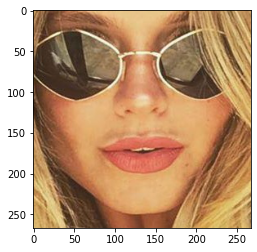

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("/content/data/1/10926324_2.jpg")
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


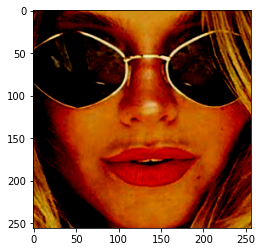

In [10]:
# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path="/content/data/img.jpg")
plt.imshow(img_cropped.permute(1, 2, 0))




# Face detecting sur toutes les images :

In [11]:
import glob
images_0=glob.glob("/content/data/0/*jpg")
images_1=glob.glob("/content/data/1/*jpg")
print(len(images_1))
images_1_train = images_1[:int(len(images_1)*0.9)]
images_1_test = images_1[int(len(images_1)*0.9):]
images_0_train = images_0[:int(len(images_0)*0.9)]
images_0_test = images_0[int(len(images_0)*0.9):]

146


In [0]:
from tqdm import tqdm

In [0]:
def new_data(name,types):
  for image in tqdm(name):
    img = Image.open(image)
    img_cropped = mtcnn(img,save_path="/content/data_crop_"+ types + image[13:])

In [14]:
new_data(images_1_test, "test")

100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


In [15]:
new_data(images_0_test, "test")

100%|██████████| 103/103 [00:31<00:00,  3.30it/s]


In [16]:
new_data(images_0_train,"train")
new_data(images_1_train,"train")

100%|██████████| 131/131 [00:28<00:00,  4.64it/s]


# Entrainement d'un pretrained NN pour détecter les lunettes

In [0]:
train_transforms = transforms.Compose([ #data augmentation and normalization for the training set
    transforms.Resize((256)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([#normalisation of the data for the testing set                            
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_loader = torch.utils.data.DataLoader(
    
   datasets.ImageFolder("/content/data_crop_train" ,
                        transform=train_transforms),
   batch_size=8, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("/content/data_crop_test",
                         transform=test_transforms),
    batch_size=8, shuffle=True, num_workers=1)

In [0]:
pretrained = True #put it at false if you don't want a pretrained network
number_epoch = 5 #number of epochs
#importation of a pretrained resnet152 and change the last fully connected layer to adapt it for the classification
model = models.resnet152(pretrained=pretrained)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,2)


In [0]:
#define an adaptative learning rate which will decrease with the number of epochs
def adjust_learning_rate(epoch):
    lr = 0.001

    if epoch > 100:
        return lr / 1000000
    elif epoch > 60:
        return lr / 100000
    elif epoch > 50:
        return lr / 10000
    elif epoch > 30:
        return lr / 1000
    elif epoch > 20:
        return lr / 100
    elif epoch > 10:
        return lr / 10
    return lr


# From scratch :

In [46]:
#boolean to know if gpu is available
use_cuda = torch.cuda.is_available()


# Create experiment folder
if not os.path.isdir("best_models"):
    os.makedirs("best_models")

if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model.cuda()
    
else:
    print('Using CPU')

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #We will use a SGD for optimizer

def train(epoch):  #the train for a single epoch
    model.train() 
    for batch_idx, (data, target) in enumerate(train_loader): #for each batch
        if use_cuda: #if cuda available, move the data and target to gpu
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean') #We decide to use cross entropy loss for classification
        loss = criterion(output, target) #calculate the loss
        loss.backward() #do the backpropagation
        optimizer.step()
        if batch_idx % 50 == 0: #We print the results 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validation(): #the evaluation of the test dataset
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader: #for each data target in the data loader
        if use_cuda: #if gpu is available, we move the data and target to gpu
            data, target = data.cuda(), target.cuda()
        output = model(data) 
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean') 
        validation_loss += criterion(output, target).data.item() #compute the loss
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] #store the preduction
        correct += pred.eq(target.data.view_as(pred)).cpu().sum() #add +1 if the prediction is correct otherwise 0

    validation_loss /= len(val_loader.dataset) #calculate the loss
    #print the loss and the precision of the test set
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


lr = 0.001
for epoch in range(1, number_epoch + 1): #for each epoch
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9) #initialise the optimizer 
    train(epoch) #do the training of the epoch
    validation() #and the validation 
    model_file = 'best_models' + '/model_' + str(epoch) + '.pth' 
    torch.save(model.state_dict(), model_file) #save the weight of the model
    lr = adjust_learning_rate(epoch) #adjust the learning rate
    print('Saved model to ' + model_file )


Using GPU
Train Epoch: 1 [0/942 (0%)]	Loss: 0.684625
Train Epoch: 1 [400/942 (42%)]	Loss: 0.200249
Train Epoch: 1 [800/942 (85%)]	Loss: 0.020362

Validation set: Average loss: 0.0036, Accuracy: 110/110 (100%)
Saved model to best_models/model_1.pth
Train Epoch: 2 [0/942 (0%)]	Loss: 0.011748
Train Epoch: 2 [400/942 (42%)]	Loss: 0.014448
Train Epoch: 2 [800/942 (85%)]	Loss: 0.029418

Validation set: Average loss: 0.0025, Accuracy: 109/110 (99%)
Saved model to best_models/model_2.pth
Train Epoch: 3 [0/942 (0%)]	Loss: 0.067737
Train Epoch: 3 [400/942 (42%)]	Loss: 0.105889
Train Epoch: 3 [800/942 (85%)]	Loss: 0.012530

Validation set: Average loss: 0.0008, Accuracy: 110/110 (100%)
Saved model to best_models/model_3.pth
Train Epoch: 4 [0/942 (0%)]	Loss: 0.004603
Train Epoch: 4 [400/942 (42%)]	Loss: 0.007473
Train Epoch: 4 [800/942 (85%)]	Loss: 0.002969

Validation set: Average loss: 0.0020, Accuracy: 109/110 (99%)
Saved model to best_models/model_4.pth
Train Epoch: 5 [0/942 (0%)]	Loss: 0.0015

# Ou en chargeant les poids que j'ai sauvegardé ( 100 % sur le validation set en 5 epochs )

In [0]:
weight_path = "/content/best_models/model_5.pth" #put the pass of the weight

In [48]:
model = models.resnet152(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,2)

state_dict = torch.load(weight_path)
model.load_state_dict(state_dict)
model.eval()

if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')
        


Using GPU


# Résultats quantitatifs (accuracy)

In [49]:
validation() 


Validation set: Average loss: 0.0005, Accuracy: 110/110 (100%)


# Résultats qualitatifs 

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


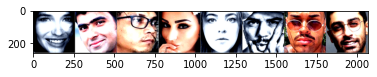

GroundTruth:  pas lunettes || pas lunettes || lunettes || pas lunettes || pas lunettes || pas lunettes || lunettes || lunettes ||
Predicted:  pas lunettes || pas lunettes || lunettes || pas lunettes || pas lunettes || pas lunettes || lunettes || lunettes ||


In [60]:
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("/content/data_crop_test",
                         transform=test_transforms),
    batch_size=8, shuffle=True, num_workers=1)

classes = ('pas lunettes ||', 'lunettes ||')
dataiter = iter(val_loader)
images, labels = dataiter.next()
if use_cuda:
  images, labels = images.cuda(), labels.cuda()
imshow(torchvision.utils.make_grid(images)) #We show images from test dataset
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8))) #avec leurs vrai labels

#et on affiche nos predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))
